In [79]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import GroundwaterDupuitPercolator

In [114]:
base_depth = 22.0  # depth of aquifer base below ground level, m
initial_water_table_depth = 2.0  # starting depth to water table, m
dx = 100.0 # cell width, m
pumping_rate = 0.001  # pumping rate, m3/s
well_locations = [800, 1200]

In [115]:
boundaries = {'top': 'closed','bottom': 'closed','right':'closed','left':'closed'}
grid = RasterModelGrid((41, 41), xy_spacing=dx, bc=boundaries)

elev = grid.add_zeros('node', 'topographic__elevation')

base = grid.add_zeros('node', 'aquifer_base__elevation')
base[:] = elev - base_depth

wt = grid.add_zeros('node', 'water_table__elevation')
wt[:] = elev - initial_water_table_depth

recharge = grid.add_zeros('node', 'recharge__rate')
recharge[well_locations] = -pumping_rate / (dx * dx)  # pumping rate, in terms of recharge

In [116]:
K = 0.001 # hydraulic conductivity, (m/s)
n = 0.2  # porosity, (-)
dt = 3600.0  # time-step duration, s
gdp = GroundwaterDupuitPercolator(
    grid, 
    hydraulic_conductivity=K, 
    porosity=n, 
    recharge_rate=recharge,
    regularization_f=0.01)

In [117]:
def run_for_one_day(gdp, dt):
    num_iter = int(3600.0 * 24 / dt)
    for i in range(num_iter):
        gdp.run_one_step(dt)

In [121]:
def run_for_one_year(gdp, dt):
    num_iter = int(365.25 * 3600.0 * 24 / dt)
    for i in range(num_iter):
        gdp.run_one_step(dt)

In [122]:
run_for_one_year(gdp, dt)

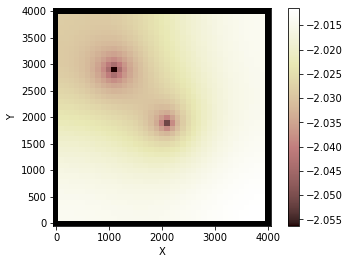

In [123]:
imshow_grid(grid, wt)

### Aside: calculating a reasonable pumping rate in terms of recharge

Suppose you're pumping 16 gallons/minute (horrible units of course). That equates to:

16 gal/min x 0.00378541 m3/gal x (1/60) min/sec =

In [11]:
16.0 *  0.00378541 / 60.0

0.0010094426666666667

...equals about 0.001 m3/s. Call that $Q_p$. The corresponding negative recharge in a cell of dimensions $\Delta x$ by $\Delta x$ would be

$R_p = Q_p / \Delta x^2 = 10^{-5}$ m/s